# Final project

The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable
$\eta: [0,1]\times[0,1]\times[0,T]$ usually written compactly as $\eta(x,t)$,
where $x = (x_0, x_1) \in \Omega:=[0,1]\times[0,1]$ and $t\in[0,T]$,
and is given by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \Delta \eta +\frac{\partial
f}{\partial \eta}(\eta) = 0, \qquad n\cdot\nabla\eta = 0 \text{ on } \partial \Omega,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and
$\varepsilon$ is the characteristic width of the phase transition. $n$ is the
outer normal to the boundary. 

Where 
$$
\nabla \eta := (\frac{\partial \eta}{\partial x_0}, \frac{\partial \eta}{\partial
x_1})
$$
and
$$
\Delta \eta := \frac{\partial^2 \eta}{\partial x_0^2} + \frac{\partial^2 \eta}{\partial
x_1^2}
$$


This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]\times[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + dt \varepsilon^2 \Delta\eta_k - \frac{\partial
f}{\partial \eta}(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $dt \varepsilon^2 \Delta\eta_k$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - dt \varepsilon^2 \Delta\eta_{k+1} = \eta_{k} - dt f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is similar to
solving at each time step a system matrix similar to the L2 projection matrix.

We use the notation 

$$
(u,v) := \int_\Omega u(x) v(x) dx = \int_0^1 \int_0^1 u(x_0, x_1) v(x_0, x_1)\textrm{d}x_0\textrm{d}x_1
$$

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + dt \varepsilon^2  (\nabla v_i, \nabla v_j)\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - dt (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand
side.

Notice that we have used *integration by parts* and the boundary conditions, i.e., 
$$
-(\Delta \eta, v) = (\nabla \eta, \nabla v) -\int_{\partial \Omega} n\cdot
\nabla \eta v
$$
and the last term is zero since we ask $n\cdot \nabla \eta$ to be zero on
$\partial \Omega$.

This results in a linear system

$$
[A] [\eta_{k+1}] = [b]
$$

where 

$$
[A]_{ij} = M_{ij}+ dt \varepsilon^2 K_{ij} = \big((v_i, v_j) + dt \varepsilon^2  (\nabla v_i, \nabla v_j)\big) 
$$

and 

$$
[b]_i = M_{ij} \big(\eta_k^j - f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the
*integral of the interpolation* of $f'(\eta)$.

## One dimensional considerations

If we need to compute $\int_0^1 v_i(x) v_j(x) dx$, then the following things are
needed first:

1. We choose the interpolation points that define our basis functions: $\{X_i\}_{i=0}^{n-1}$
2. We compute the degree of the polynomial that results from multiplying $v_i$
   and $v_j$. In this case `k = 2 len(X)-2$
3. We pick the Gauss quadrature rule that can integrate exactly a polynomial of
   degree at least `k`, that is a Gauss quadrature rule with with `nq` points,
   such that `2*nq-1` (maximum degree of accuracy) is greater than `k=2*n-2`,
   that is we pick a Gauss quadrature formula with `n` points.
4. We compute $v_i(q_k)$ for all $q_k$ in the quadrature points (notice that
   these are not in general the identity matrix...)

Then the resulting matrix can be written as

$$
M^1_{ij} := \int_0^1 v_i(x) v_j(x) dx = \sum_{k=0}^{n} v_i(q_k) v_j(q_k) w_k
$$
where $q_k, w_k$ are the quadrature points and weights computed above.

The same is true for the one dimensional stiffness matrix. In this case we also
need a function that computes
5. $v_i'(q_k)$ for all $q_k$ in the quadrature points 

$$
K^1_{ij} := \int_0^1 v_i'(x) v_j'(x) dx = \sum_{k=0}^{n} v_i'(q_k) v_j'(q_k) w_k
$$

## Tensor product structure for two dimensions

Notice that, if we choose the basis functions to be tensor product basis, i.e.,
$v_{ij} = v_i(x_0)v_j(x_1)$, we can compute the matrix $M$ as

$$
\begin{split}
\alpha = i n+j, \beta = kn+l, \qquad M_{\alpha\beta} = M^2_{ijkl} & := \int_\Omega v_{ij}(x)v_{kl}(x) \mathrm{d}x = \int_0^1 \int_0^1
v_{i}(x_0)v_{j}(x_1)v_{k}(x_0)v_{l}(x_1) \mathrm{d}x_0\mathrm{d}x_1  \\
 & = \int_0^1 v_{i}(x_0) v_{k}(x_0) \mathrm{d}x_0 \int_0^1
v_{j}(x_1)v_{l}(x_1) \mathrm{d}x_1 \\
& = M^1_{ik} M^1_{jl}\\
M^1_{ik} &:= \int_0^1 v_{i}(x_0) v_{k}(x_0) \mathrm{d}x_0 
\end{split}
$$

The version with two indices for matrices ($M_{\alpha\beta}$) and one index for
basis functions $v_i$ can be obtained as a `reshape` to two dimensional matrices
of the $(n,n,n,n)$ tensor $M_{ijkl}$ above, and to one dimensional arrays $\eta^{ij}$

# Building the stiffness matrix in 2d

In order to build the stiffness matrix in 2d, using the tensor product
structure, we observe that 

$$
\begin{split}
K_{\alpha\beta} = K^2_{ijkl} & :=
\int_\Omega \nabla v_{ij}(x) \cdot \nabla v_{kl}(x) \mathrm{d}x \qquad \alpha =
i n+j, \beta = kn+l \\
& = \int_\Omega \frac{\partial v_{ij}}{\partial x_0}(x)  \frac{\partial
v_{kl}}{\partial x_0}(x) + \frac{\partial v_{ij}}{\partial x_1}(x)  \frac{\partial
v_{kl}}{\partial x_1}(x) \mathrm{d}x
\\
& = \int_0^1 \int_0^1 
\frac{\partial v_{i}}{\partial x_0}(x_0) v_{j}(x_1)
\frac{\partial v_{k}}{\partial x_0}(x_0) v_{l}(x_1)
+
v_{i}(x_0) \frac{\partial v_{j}}{\partial x_1}(x_1)
v_{k}(x_0) \frac{\partial v_{l}}{\partial x_1}(x_1)
\mathrm{d}x_0\mathrm{d}x_1  
\\
& = \int_0^1
\frac{\partial v_{i}}{\partial x_0}(x_0)
\frac{\partial v_{k}}{\partial x_0}(x_0) 
\mathrm{d}x_0 \int_0^1 
 v_{j}(x_1)
 v_{l}(x_1)
\mathrm{d}x_1 
+
\int_0^1
v_{i}(x_0) 
v_{k}(x_0)
\mathrm{d}x_0 \int_0^1 
\frac{\partial v_{j}}{\partial x_1}(x_1)
\frac{\partial v_{l}}{\partial x_1}(x_1)
 \mathrm{d}x_1 
\\
&= K^1_{ik} M^1_{jl} + M^1_{ik} K^1_{jl} 
\end{split}
$$

So to assemble two (or three) dimensional stiffness matrices in tensor product
structures, we only need the one dimensional mass and stiffness matrices $M^1$,
and $K^1$.


## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used for the computation of $L^2$ matrix.

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]\times[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, and polynomial degree `k` in each coordinate direction.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


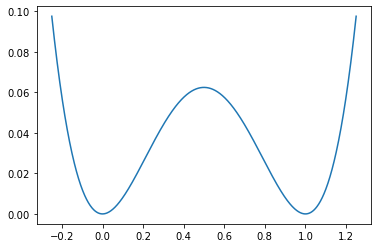

In [7]:
x = linspace(-.25,1.25, 1025)

plot(x, x**2*(x-1)**2)